In [14]:
%reload_ext autoreload
%autoreload 2

# Módulos externos
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

### Lectura de los datos del .csv

In [4]:
df_original = pd.read_csv("data/bboxes_labels.csv",skipinitialspace=True)
df_original

,file_name,bbox,x1,y1,x2,y2,width,height,bbox_area,mask_area,drops
0,img0001.jpg,0,0,0,0,0,0,0,0,0,0
1,img0002.jpg,0,67,116,96,155,29,39,1131,801,1
2,img0002.jpg,1,126,119,146,148,20,29,580,497,1
3,img0002.jpg,2,330,117,352,142,22,25,550,401,1
4,img0002.jpg,3,449,120,467,138,18,18,324,175,1
...,...,...,...,...,...,...,...,...,...,...,...
948,img0220.jpg,0,0,117,26,175,26,58,1508,1177,1
949,img0220.jpg,1,107,112,188,172,81,60,4860,4097,1
950,img0220.jpg,2,262,112,371,172,109,60,6540,4802,2
951,img0220.jpg,3,426,113,547,173,121,60,7260,3830,4


In [7]:
# Dataframe de features
headers = df_original.columns
df_features = df_original[headers[2:10]]
df_features

,x1,y1,x2,y2,width,height,bbox_area,mask_area
0,0,0,0,0,0,0,0,0
1,67,116,96,155,29,39,1131,801
2,126,119,146,148,20,29,580,497
3,330,117,352,142,22,25,550,401
4,449,120,467,138,18,18,324,175
...,...,...,...,...,...,...,...,...
948,0,117,26,175,26,58,1508,1177
949,107,112,188,172,81,60,4860,4097
950,262,112,371,172,109,60,6540,4802
951,426,113,547,173,121,60,7260,3830


In [9]:
# Dataframe de etiquetas
df_labels = df_original[headers[10]]
df_labels

0      0
1      1
2      1
3      1
4      1
      ..
948    1
949    1
950    2
951    4
952    3
Name: drops, Length: 953, dtype: int64

In [12]:
# Conversión de features a matriz NumPy
arr_features = df_features.to_numpy()

# Conversión de etiquetas a matriz NumPy
arr_labels = df_labels.to_numpy()

print("Dimensiones de la matriz de features:", arr_features.shape)
print("Dimensiones de la matriz de etiquetas:", arr_labels.shape)

Dimensiones de la matriz de features: (953, 8)
Dimensiones de la matriz de etiquetas: (953,)


In [68]:
# Normalización de las features

arr_features_norm = []
for feature in arr_features:
    x1 = feature[0]/800
    y1 = feature[1]/600
    x2 = feature[2]/800
    y2 = feature[3]/600
    width = feature[4]/800
    height = feature[5]/600
    bbox_area = feature[6]/(800*600)
    mask_area = feature[7]/(800*600)
    arr_features_norm.append(np.array([x1, y1, x2, y2, width, height, bbox_area, mask_area]))
arr_features_norm = np.array(arr_features_norm)

print(arr_features_norm.shape)

(953, 8)


### Entrenamiento del modelo

In [112]:
# Split de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(arr_features_norm, arr_labels, test_size=0.2, random_state=42)

In [113]:
# Creación del modelo
model = Sequential([
    Dense(128, activation='relu', input_shape=(8,)),  # Capa oculta con 64 neuronas
    Dense(32, activation='relu'),                   # Otra capa oculta
    Dense(1)                                        # Capa de salida (sin activación para regresión)
])

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,313 (20.75 KB)

 Trainable params: 5,313 (20.75 KB)

 Non-trainable params: 0 (0.00 B)

In [114]:
# Compilación del modelo
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='mse',          # Error cuadrático medio como función de pérdida
              metrics=['mae'])     # Error absoluto medio como métrica adicional

In [ ]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train,
                    epochs=200, 
                    batch_size=5, 
                    validation_split=0.2,
                    verbose=1)

Epoch 1/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.0195 - mae: 2.2941 - val_loss: 6.5155 - val_mae: 1.8380
Epoch 2/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5755 - mae: 1.8622 - val_loss: 4.9721 - val_mae: 1.4293
Epoch 3/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7960 - mae: 1.8571 - val_loss: 3.8513 - val_mae: 1.3318
Epoch 4/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3588 - mae: 1.6410 - val_loss: 3.4682 - val_mae: 1.3707
Epoch 5/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2420 - mae: 1.6255 - val_loss: 3.3421 - val_mae: 1.4134
Epoch 6/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2537 - mae: 1.6739 - val_loss: 3.1451 - val_mae: 1.3776
Epoch 7/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0415 - mae: 1.6507 - val_loss: 2.9961 - val_mae: 1.3609
Epoch 8/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4626 - mae: 1.5523 - val_loss: 2.8461 - val_mae: 1.3365
Epoch 9/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

In [ ]:
# Evaluar el modelo
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nError absoluto medio en prueba: {test_mae:.4f}")


Error absoluto medio en prueba: 0.4726


In [ ]:
# Hacer predicciones
y_pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


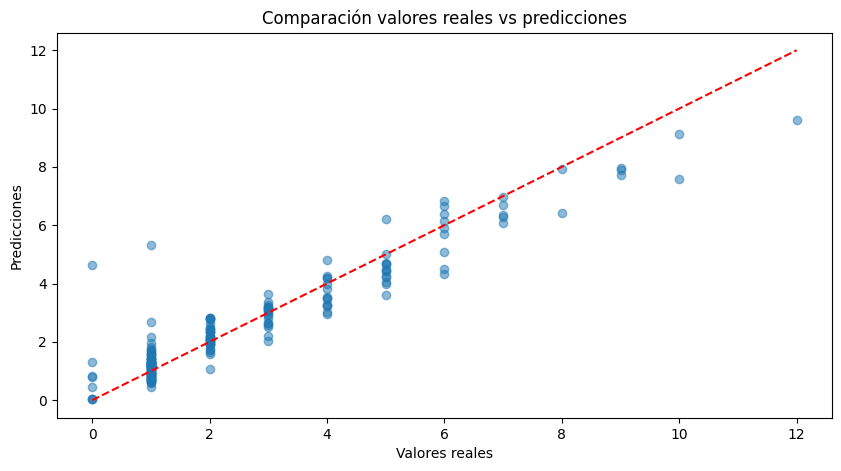

In [118]:
# 8. Visualizar resultados (opcional)
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Comparación valores reales vs predicciones')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()

In [ ]:
# Guardar el modelo
model.save('models/dropcounter_v01_model.keras')  # Puedes usar .h5 o .keras

# Para cargar y usar el modelo en otro código:
"""
from tensorflow.keras.models import load_model

# Cargar el modelo
loaded_model = load_model('mi_modelo_regresion.keras')

# Hacer una predicción con nuevos datos
nuevos_datos = np.array([[x1, y1, x2, y2, bbox_w, bbox_h, bbox_a, mask_a]])  # Reemplaza con tus valores
prediccion = loaded_model.predict(nuevos_datos)
print(f"Predicción: {prediccion[0][0]}")
"""